In [55]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import pandas as pd
import re       
import string 
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import requests
from bs4 import BeautifulSoup as BS 
import time

!pip install contractions # instalamos
import contractions # importamos

!pip install pysrt
import pysrt

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
rootaddress = '/content/drive/My Drive/Maarja project/Data/SRT puros/'

**Adapts the srt text to a continuous one.**

In [57]:
def srttotext(algo):  
  text =" "
  with open(rootaddress + algo + '.srt','r') as f:          # Gets srt files from Drive based on its title
      for line in f:
        if  not line[0].isdigit():
            text+= " " + line.replace('\n','')
            text = text.lstrip().replace('</i>', '').replace('<i>', '')
  text = contractions.fix(text) 
  return text

**Text cleaning of punctuation based on regular expression.**

In [58]:
def clean1(text): 
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text) 
    text = re.sub('\w*\d\w*', '', text)  
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text 

**Tokenizes and lemmatizes.**

In [59]:
def clean2(text):
  text = clean1(text)
  words = word_tokenize(text)                       # Tokenizes text
  words_clean = []
  for w in words:                                   # Appends lemmatized non-stopwords
    if not w in stop_words: 
      words_clean.append(lemmatizer.lemmatize(w))
  text = ' '.join(words_clean)
       
  text = word_tokenize(text)
  return ' '.join(text)

**Compares the cosine similarity between two texts.**

In [60]:
def compute_cosine_similarity(text1, text2):
    
    list_text = [text1, text2]
    
    vectorizer = TfidfVectorizer(stop_words='english')  # Creates term frequency - inverse document frequency to scale down the weight of tokens that appear in many documents.
    vectorizer.fit_transform(list_text)
    tfidf_text1, tfidf_text2 = vectorizer.transform([list_text[0]]), vectorizer.transform([list_text[1]])
    
    cs_score = cosine_similarity(tfidf_text1, tfidf_text2)  # Scores the cosin similarity
    
    return np.round(cs_score[0][0],2)

In [61]:
lemmatizer = WordNetLemmatizer()                      # Loads lemmatizer model
stop_words = nltk.corpus.stopwords.words('english')   # Loads ntlk englishs topwords
stop_words = stop_words + ["'s", 's', 'u', 'us','know', 'one', 'want', 'going', 'go', 'got', 'right', 'come', 'take'] # Adds new stopwords

**Plots a Word Cloud based on movie's srt.**

In [62]:
def wordcloud_srt(algo):                              
 
  fig, ax = plt.subplots(1, 4, figsize = (22,8))

  wc_atributos = {'height' : 600,                        # Word Cloud specs
                      'width' : 1000,
                      'background_color' : 'white',
                      'max_words' : 60
                      }

  for a in range(len(algo)):                            # Iterates over movies titles
    wc = WordCloud(**wc_atributos)
    ax[a].set_title(algo[a])
    wc.generate(clean2(srttotext(algo[a])))             # Cleans srt files from Drive
    ax[a].imshow(wc, interpolation="bilinear")  
    ax[a].axis("off")
  plt.show()    

**Plots a Word Cloud based on movie's plot from wikipedia.**

In [63]:
def wordcloud_plot(algo): 
 
  fig, ax = plt.subplots(1, 4, figsize = (22,8))

  wc_atributos = {'height' : 600,                              # Word Cloud specs
                      'width' : 1000,
                      'background_color' : 'white',
                      'max_words' : 60
                      }

  for a in range(len(algo)):                                  # Iterates over movies titles
    wc = WordCloud(**wc_atributos)
    ax[a].set_title(algo[a])
    wc.generate(clean2(scrap1(listwikipediapath[a])))         # Web scraps wikipedia page
    ax[a].imshow(wc, interpolation="bilinear")  
    ax[a].axis("off")
  plt.show()    

**Plots a heatmap of cosine similarity between movies from the srt files.**

In [64]:
def heatmapsrt(algo):
  
  lista2 = []
  for a in range(len(algo)):
    lista2.append(clean2(srttotext(algo[a])))

  size_m = len(lista2)
  matriz =  np.zeros(size_m * size_m).reshape(size_m, size_m)
  for a in range(size_m):
    for b in range(size_m):
      matriz[a][b] = compute_cosine_similarity(lista2[a], lista2[b])
    
  fig, ax = plt.subplots(figsize = (8,8))
  im = ax.imshow(matriz, vmin = 0, vmax = 1)

  ax.set_yticks(range(len(algo)))
  ax.set_yticklabels(algo, fontsize = 12)
  ax.set_xticks(range(len(algo)))
  ax.set_xticklabels(algo, fontsize = 12, rotation = 90)

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
        text = ax.text(j, i, matriz[i, j],
                       ha="center", va="center", color="w")

  fig.suptitle('Similarities between movies according to their subtitles', fontsize = 15)
  fig.colorbar(im, orientation = 'vertical')
  plt.show()  

**Plots a heatmap of cosine similarity between movie's plot from wikipedia.**

In [65]:
def heatmapplot (algo):
  
  lista2 = []
  for a in range(len(algo)):
    lista2.append(clean2(scrap1(algo[a])))

  size_m = len(lista2)
  matriz =  np.zeros(size_m * size_m).reshape(size_m, size_m)
  for a in range(size_m):
    for b in range(size_m):
      matriz[a][b] = compute_cosine_similarity(lista2[a], lista2[b])
    
  fig, ax = plt.subplots(figsize = (8,8))
  im = ax.imshow(matriz, vmin = 0, vmax = 1)

  ax.set_yticks(range(len(algo)))
  ax.set_yticklabels(algo, fontsize = 12)
  ax.set_xticks(range(len(algo)))
  ax.set_xticklabels(algo, fontsize = 12, rotation = 90)

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
        text = ax.text(j, i, matriz[i, j],
                       ha="center", va="center", color="w")

  fig.suptitle("Similarities between movies according to their Wikipedia's Plot", fontsize = 15)
  fig.colorbar(im, orientation = 'vertical')
  plt.show()  

**Web scrapes the movie's plot from wikipedia.**

In [66]:
def scrap1(algo):

  link = 'https://en.wikipedia.org/wiki/' + algo
  response = requests.get(link)
  soup = BS(response.content)
  
  la = soup.find_all('div', {'class': 'mw-parser-output'})  
  
  if (len(la)>1):                                               # Gets the last value from 'la' list in case of many values.
    li=la[-1]
  else:
    li = la[0]

  list2=[]
  children = li.findChildren(recursive=False)                   # Gets children from ('div', {'class': 'mw-parser-output'})
  count=0
  indice=[]
  for child in children:                                        # Only if 'h2 and 'indice' list less than 2 values (start and finish index number)
    if ((str(child)[:4]=='<h2>') and (len(indice)<2)):          # Gets the h2 header with its start and finish index from children list
      indice.append(count)
    count+=1

  texto=[]
  for a in range(indice[0]+1, indice[1], 1):                              # Gets texts from 'children' list based on the start and finish index range from 'indice'
    if (children[a].get_text()[:30] == 'This article needs an improved'): # Avoids non text info
      pass
    else:
      texto.append(children[a].get_text())                                  # Appends and join text                             
  texto_3 = ' '.join(texto)
  
  return(texto_3)

**List of srt files's name and list of the partial link path of movie's plot in**

In [67]:
listsrtfile = ['Batman Begins (2005)', 'Life Is Beautiful (1997)', 'The  Matrix Reloaded (2003)','The Matrix (1999)', 'Saving Private Ryan (1998)', 
         'Snatch (2000)', 'Terminator 2 - Judgement Day (1991)', 'The Godfather (1972)', 'The Dark Knight (2008)', 'The Fast and the Furious (2001)', 
         'TLOTR The Fellowship of the Ring (2001)', 'Gladiator (2000)', 'The Hobbit An Unexpected Journey (2012)']

listwikipediapath = ['Batman_Begins', 'Life_Is_Beautiful', 'The_Matrix_Reloaded', 'The_Matrix', 'Saving_Private_Ryan', 'Snatch_(film)', 
             'Terminator_2:_Judgment_Day', 'The_Godfather', 'The_Dark_Knight', 'The_Fast_and_the_Furious_(2001_film)',   
             'The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring', 'Gladiator_(2000_film)', 'The_Hobbit:_An_Unexpected_Journey' ]

**Plos the heatmap of cosine similarity based on wikipedia's plot. The  function hardly find any similarity between movies except from the same movie or related with sequels of the movie.**

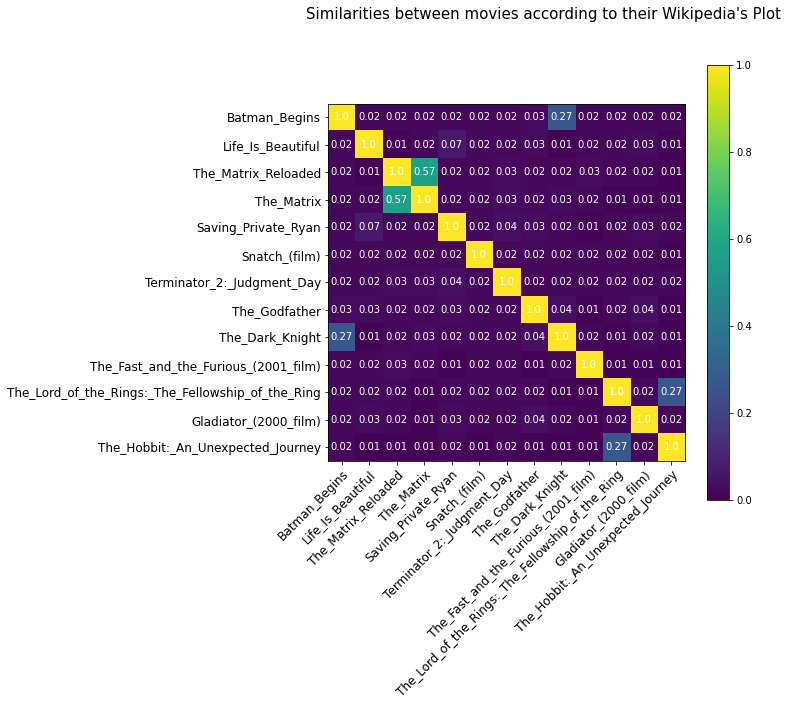

In [68]:
heatmapplot(listwikipediapath)

**With a heatmap of movies's srt we observe better score of similarity.**

---



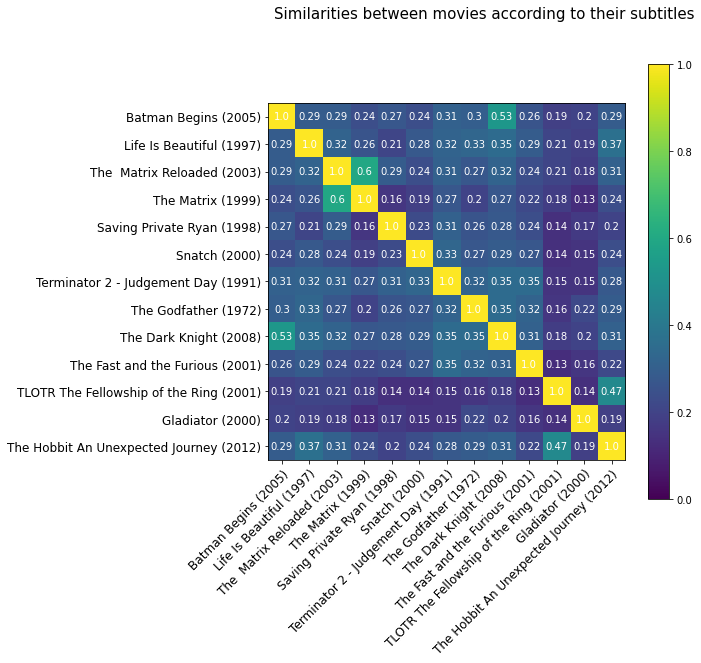

In [69]:
heatmapsrt(listsrtfile)

**One explanation could be that srt's files have almost 6 time more information than the wikipedia's movies plot. The score difference it's more pronounce in wikipedia's plot but both point out the same movies with a possibility to be similar like:**
 
*   **The Dark Knight - Batman Begins**
*   **Matrix - Matrix Reloaded**
*   **The Lord of the Rings: The Fellowship of the Ring - The Hobbit: An Unexpected Journey bold text**

In [70]:
var = 0
for a in listwikipediapath:
  var+=len(scrap1(a))
print(f'Length average of wikipedia\'s movies plot: {round(var/len(listwikipediapath), 1)}')

var = 0
for a in listsrtfile:
  var+=len(clean2(srttotext(a)))
print(f'Length average of movies\'s srt: {round(var/len(listsrtfile), 1)}')

Length average of wikipedia's movies plot: 4251.2
Length average of movies's srt: 26248.2


**We take a look to the wordcloud of 4 movies. We have to take into account that the plot explain the movie while the srt's files are the conversation of the movies.**

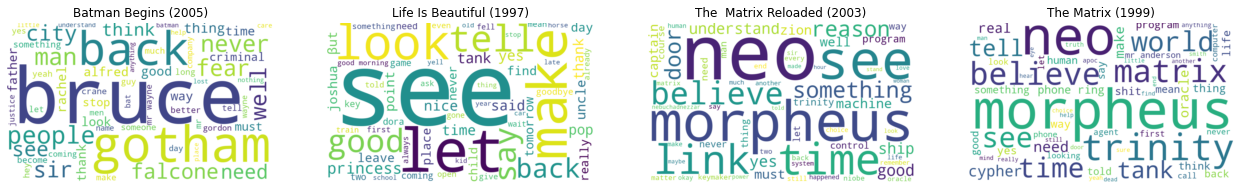

In [71]:
wordcloud_srt(listsrtfile[:4])

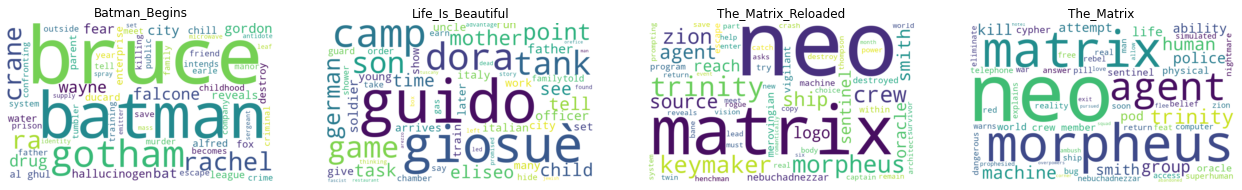

In [72]:
wordcloud_plot(listwikipediapath[:4])